CIFAR10 dataset split into neg/pos and trained using normal CNN without augmentation.  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'cnn',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['ship'],
    "num_epochs": 50,
    "batch_size": 64,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 1 1 0 0 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 0 1 1 1 1 1 1]
[1 1 1 0 1 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [5]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [6]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config['img_shape']))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(1, activation='sigmoid'))
# cnn_model.add(layers.Dense(params['num_classes'], activation='softmax'))

In [7]:
if config['verbosity'] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [8]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [9]:
def make_model():
    if config['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif config['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    cnn_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return cnn_model

In [10]:
log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')
earlystopping_cb = EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)

callbacks = [tensorboard_cb, earlystopping_cb]

## Baseline

In [11]:
baseline_model = make_model()

baseline_history = cnn_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 546 steps, validate for 117 steps
Epoch 1/50
546/546 [==============================] - 8s 14ms/step - loss: 0.2666 - tp: 30873.0000 - fp: 2776.0000 - tn: 689.0000 - fn: 606.0000 - accuracy: 0.9032 - precision: 0.9175 - recall: 0.9807 - auc: 0.8594 - val_loss: 0.7752 - val_tp: 3122.0000 - val_fp: 52.0000 - val_tn: 742.0000 - val_fn: 3572.0000 - val_accuracy: 0.5160 - val_precision: 0.9836 - val_recall: 0.4664 - val_auc: 0.8329
Epoch 2/50
546/546 [==============================] - 5s 9ms/step - loss: 0.1767 - tp: 30846.0000 - fp: 1828.0000 - tn: 1641.0000 - fn: 629.0000 - accuracy: 0.9297 - precision: 0.9441 - recall: 0.9800 - auc: 0.9316 - val_loss: 0.3230 - val_tp: 6689.0000 - val_fp: 758.0000 - val_tn: 37.0000 - val_fn: 4.0000 - val_accuracy: 0.8982 - val_precision: 0.8982 - val_recall: 0.9994 - val_auc: 0.8926
Epoch 3/50
546/546 [==============================] - 5s 9ms/step - loss: 0.1524 - tp: 30921.0000 - fp: 1478.0000 - tn: 1991.0000 - fn: 554.0000 - accuracy: 0.9418 -

`Keras`
Save/load the model

In [ ]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

#### Validate the results

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

Some functions

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [14]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [15]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [16]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

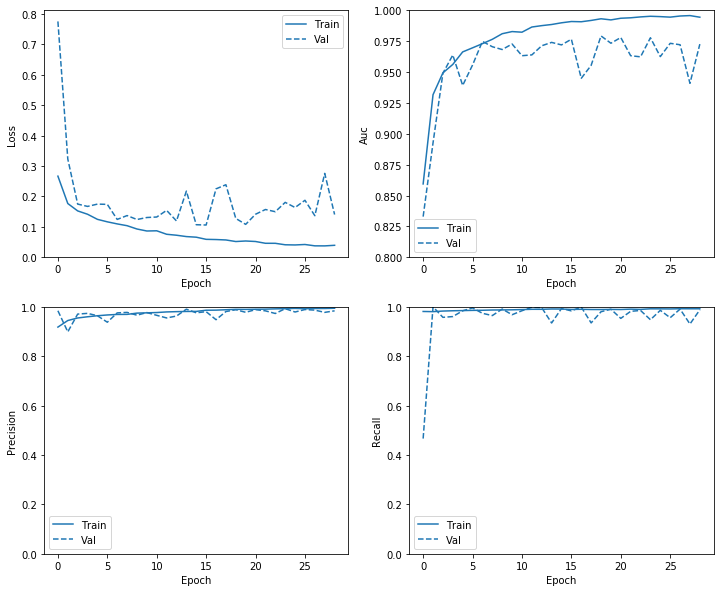

In [17]:
plot_metrics(baseline_history)

In [19]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=4000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=4000)

117/117 - 0s - loss: 0.1257 - tp: 6605.0000 - fp: 68.0000 - tn: 666.0000 - fn: 149.0000 - accuracy: 0.9710 - precision: 0.9898 - recall: 0.9779 - auc: 0.9776

loss : 0.12569420214973262
tp : 6605.0
fp : 68.0
tn : 666.0
fn : 149.0
accuracy : 0.9710202813148499
precision : 0.9898096919059753
recall : 0.9779390096664429
auc : 0.9776058197021484
Legitimate Transactions Detected (True Negatives):  380
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  53
Fraudulent Transactions Detected (True Positives):  3546
Total Fraudulent Transactions:  3599


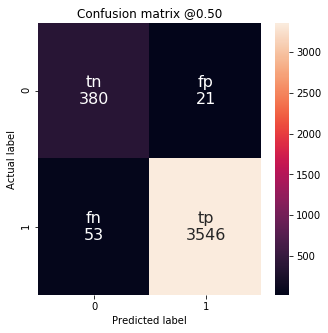

In [20]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/baseline_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()

plot_cm(train_labels_baseline, train_predictions_baseline)

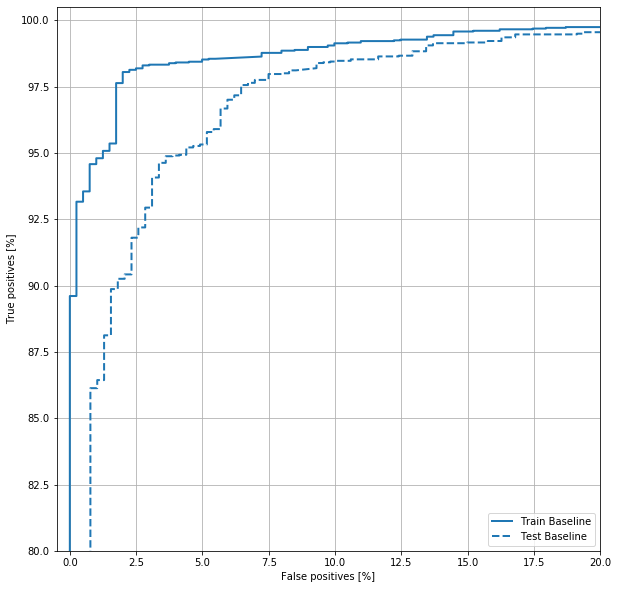

In [21]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [4]:
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.00
Weight for class 1: 0.56


In [22]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 546 steps, validate for 117 steps
Epoch 1/50
546/546 [==============================] - 7s 12ms/step - loss: 0.0577 - tp: 31132.0000 - fp: 367.0000 - tn: 3105.0000 - fn: 340.0000 - accuracy: 0.9798 - precision: 0.9883 - recall: 0.9892 - auc: 0.9909 - val_loss: 0.1086 - val_tp: 6563.0000 - val_fp: 83.0000 - val_tn: 713.0000 - val_fn: 129.0000 - val_accuracy: 0.9717 - val_precision: 0.9875 - val_recall: 0.9807 - val_auc: 0.9801
Epoch 2/50
546/546 [==============================] - 5s 9ms/step - loss: 0.0420 - tp: 31209.0000 - fp: 290.0000 - tn: 3168.0000 - fn: 277.0000 - accuracy: 0.9838 - precision: 0.9908 - recall: 0.9912 - auc: 0.9955 - val_loss: 0.1940 - val_tp: 6626.0000 - val_fp: 283.0000 - val_tn: 511.0000 - val_fn: 68.0000 - val_accuracy: 0.9531 - val_precision: 0.9590 - val_recall: 0.9898 - val_auc: 0.9441
Epoch 3/50
546/546 [==============================] - 5s 9ms/step - loss: 0.0465 - tp: 31162.0000 - fp: 284.0000 - tn: 3187.0000 - fn: 311.0000 - accuracy: 0.9830 - 

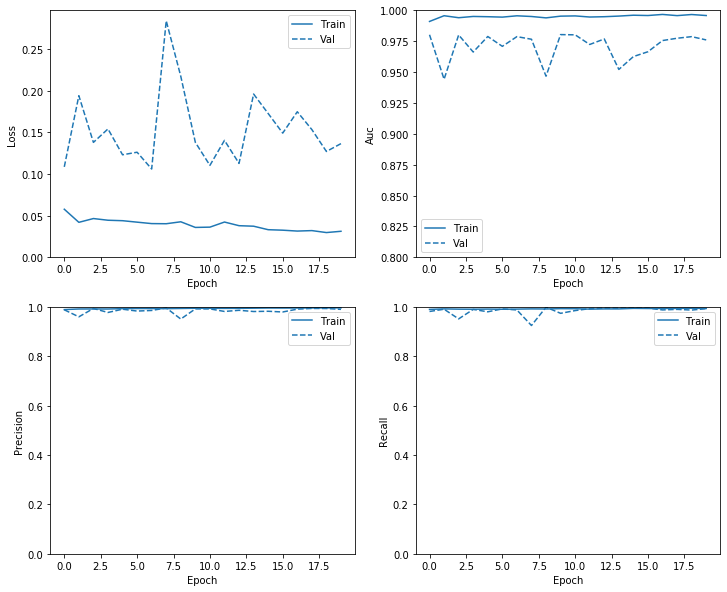

In [23]:
plot_metrics(weighted_history)

In [24]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=4000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=400)

117/117 - 0s - loss: 0.1340 - tp: 6567.0000 - fp: 61.0000 - tn: 672.0000 - fn: 188.0000 - accuracy: 0.9667 - precision: 0.9908 - recall: 0.9722 - auc: 0.9796

loss : 0.13401667253337163
tp : 6567.0
fp : 61.0
tn : 672.0
fn : 188.0
accuracy : 0.9667468070983887
precision : 0.9907966256141663
recall : 0.9721687436103821
auc : 0.9795769453048706
Legitimate Transactions Detected (True Negatives):  381
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  81
Fraudulent Transactions Detected (True Positives):  3529
Total Fraudulent Transactions:  3610


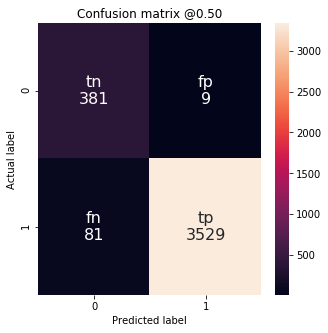

In [25]:
weighted_results = weighted_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/weighted_results.txt","w")
for name, value in zip(weighted_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()

plot_cm(train_labels_weighted, train_predictions_weighted)

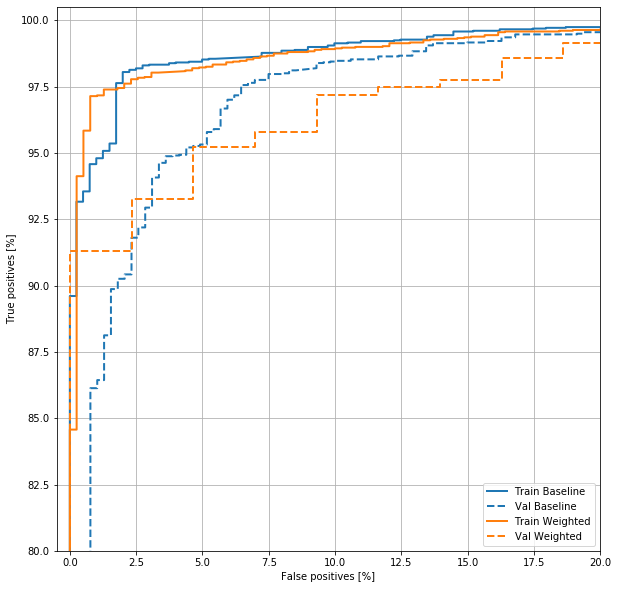

In [28]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

## Oversampling the minority class

`Tensorboard`

## Predict new samples

In [ ]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

In [ ]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

print("{:0.4f} | {}".format(pred, np.round(pred)))

prediction = ('Boat') if np.round(pred)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [ ]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')